### Library Import

In [1]:
import xarray as xr
import harp 
import contextily as cx
import numpy as np
import os
from os.path import join
import netCDF4 as nc
import matplotlib.pyplot as plt
import glob
from glob import iglob
import pandas as pd
import warnings
import time
import datetime
import geopandas as gpd
import netCDF4 as nc
import rasterio
from shapely.geometry import mapping
import rioxarray as rio
import imageio
warnings.filterwarnings('ignore')

### Reading Shapefile 

In [2]:
# Read India Shapefile 
is_shp = gpd.read_file('D:\\Ozone\\Israel_Gaza\\ISR_adm0.shp',crs="epsg:4326")
pse_shp = gpd.read_file('D:\\Ozone\\Israel_Gaza\\PSE_adm0.shp',crs="epsg:4326")

<AxesSubplot:>

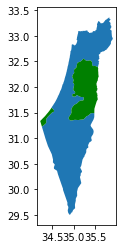

In [3]:
ax = plt.axes()
is_shp.plot(ax=ax)
pse_shp.plot(ax=ax,facecolor = 'green')

### Preprocess Data

In [4]:
# 
start_date = datetime.datetime(2021,5,10)
end_date = datetime.datetime(2021,5,23)
date_list = []
while start_date <= end_date:
    date_list.append(start_date.strftime('%Y%m%d'))
    start_date += datetime.timedelta(1)
input_file_path='D:\\Ozone\\'
out_prepro_path='D:\\Ozone\\Israel_Gaza\\Preprocessed\\'

In [5]:

for i in range(0,len(date_list)):
    file_input = sorted(glob.glob(join(input_file_path,'S5P_OFFL_L2__O3_____'+date_list[i]+'*.nc')))
    
    for j in range(len(file_input)):
        converted_o3 = harp.import_product(file_input[j],\
                                          operations = "O3_column_number_density_validity>50; \
                                          derive(O3_column_number_density [mol/m2]); \
                                          derive(datetime_stop {time} );\
                                          latitude > 29 [degree_north] ; latitude < 34 [degree_north] ; \
                                          longitude > 34 [degree_east] ; longitude < 36 [degree_east];\
                                          bin_spatial(500,29,0.01,200,34,0.01);\
                                          derive(latitude {latitude}) ; derive(longitude {longitude}) ;\
                                          keep(latitude,latitude_bounds,longitude,longitude_bounds,\
                                          O3_column_number_density)")
        harp.export_product(converted_o3,join(out_prepro_path,file_input[j].split('\\')[-1]),file_format='netcdf')
        print('product', file_input[j],'pre-processed')
print('Finished')

product D:\Ozone\S5P_OFFL_L2__O3_____20210509T100957_20210509T115127_18501_01_020104_20210511T032750.nc pre-processed
product D:\Ozone\S5P_OFFL_L2__O3_____20210510T095059_20210510T113229_18515_01_020104_20210512T032014.nc pre-processed
product D:\Ozone\S5P_OFFL_L2__O3_____20210511T093201_20210511T111331_18529_01_020104_20210513T025042.nc pre-processed
product D:\Ozone\S5P_OFFL_L2__O3_____20210512T091303_20210512T105433_18543_01_020104_20210514T022331.nc pre-processed
product D:\Ozone\S5P_OFFL_L2__O3_____20210513T103535_20210513T121705_18558_01_020104_20210515T042645.nc pre-processed
product D:\Ozone\S5P_OFFL_L2__O3_____20210514T101637_20210514T115807_18572_01_020104_20210516T040129.nc pre-processed
product D:\Ozone\S5P_OFFL_L2__O3_____20210515T095739_20210515T113909_18586_01_020104_20210517T032223.nc pre-processed
product D:\Ozone\S5P_OFFL_L2__O3_____20210516T093840_20210516T112010_18600_01_020104_20210518T030322.nc pre-processed
product D:\Ozone\S5P_OFFL_L2__O3_____20210517T091942_202

In [6]:

for i in range(0,len(date_list)):
    in_prepro_path = 'D:\\Ozone\\Israel_Gaza\\Preprocessed\\'+'S5P_OFFL_L2__O3_____'+date_list[i]+'*.nc'
    merge_path = 'D:\\Ozone\\Israel_Gaza\\Merge\\Merge_'+date_list[i]+'.nc'
    
    conv_o3 = harp.import_product(in_prepro_path,\
                             operations='\
                              keep(latitude,longitude,O3_column_number_density)',\
                             post_operations = 'bin() ; squash(time, (latitude,longitude,O3_column_number_density))')

    harp.export_product(conv_o3,merge_path ,file_format='netcdf')
    print('Merged')

Merged
Merged
Merged
Merged
Merged
Merged
Merged
Merged
Merged
Merged
Merged
Merged
Merged
Merged
Merged


### Visuaization

In [7]:
is_shp.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

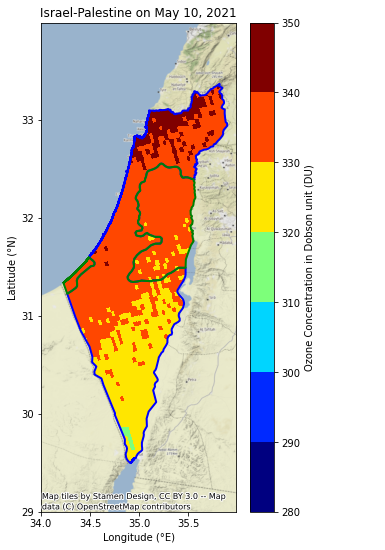

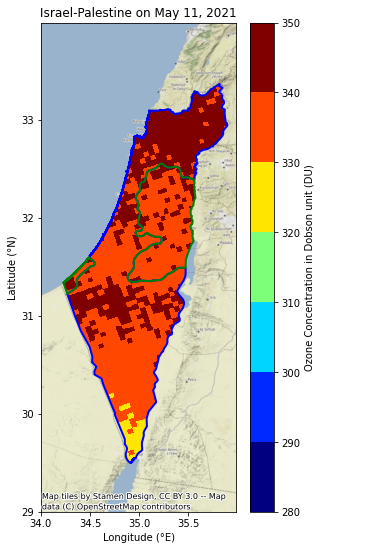

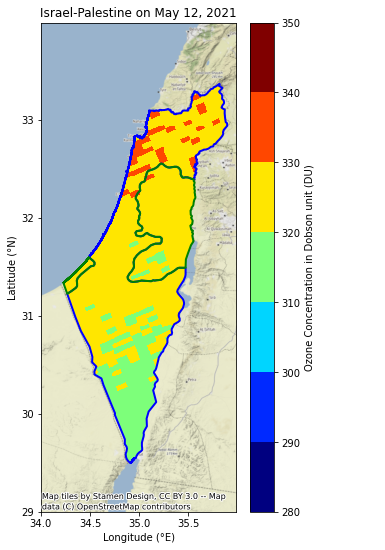

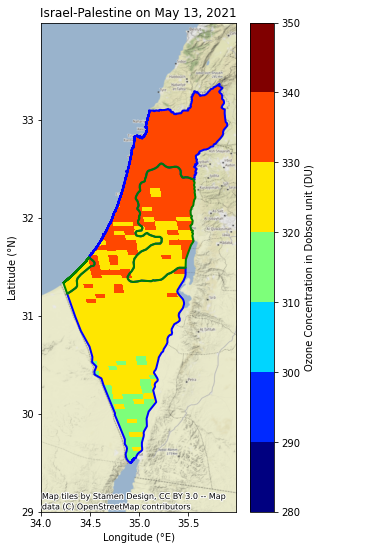

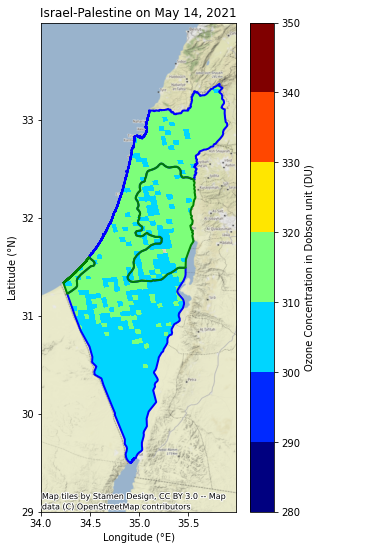

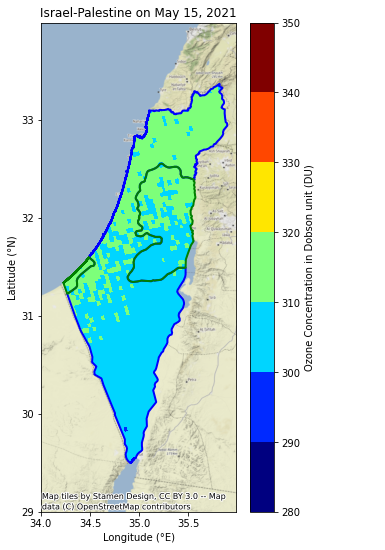

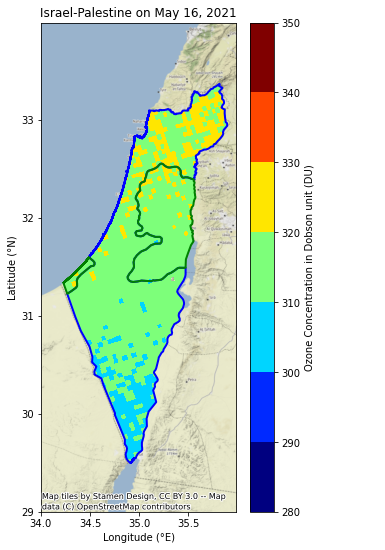

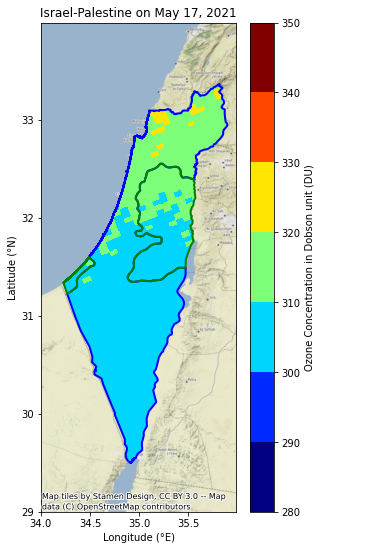

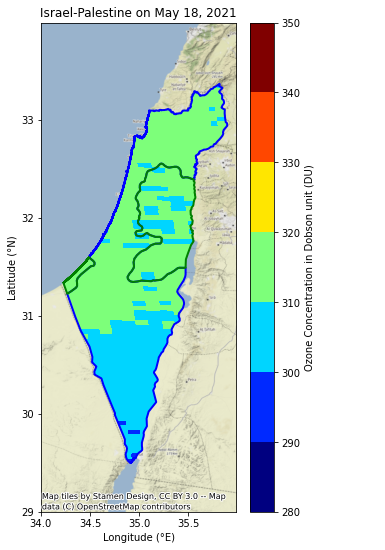

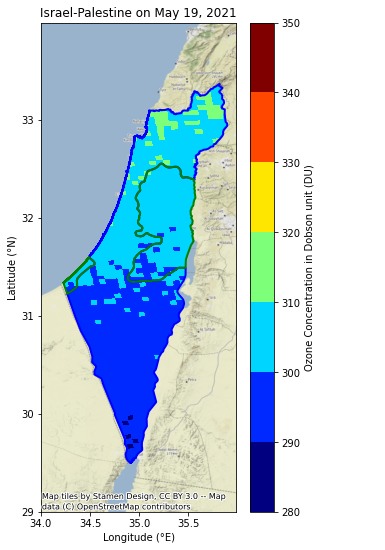

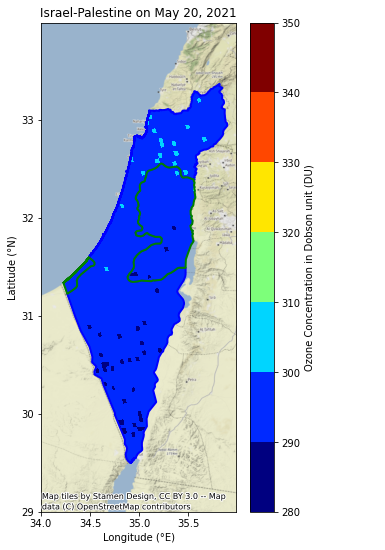

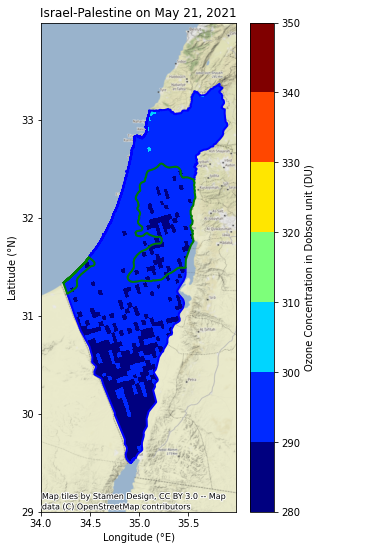

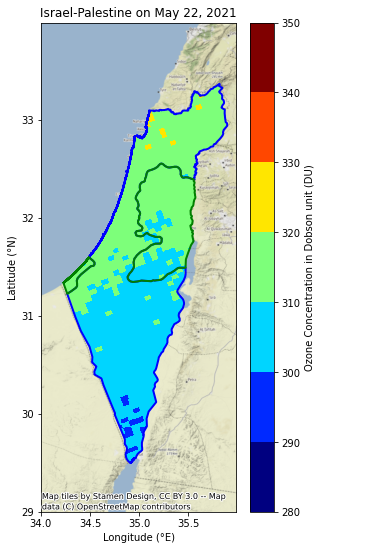

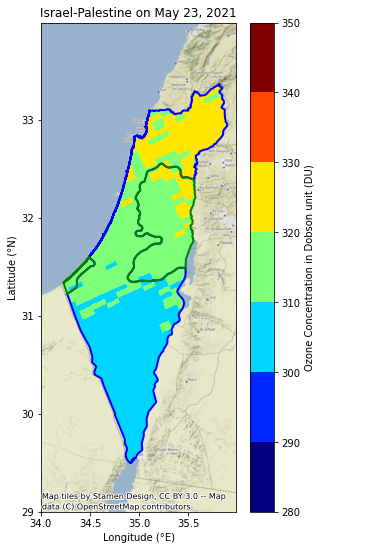

In [8]:
DU_conversion_factor = 2241.15
for i in range(0,len(date_list)):
    merge_path =  'D:\\Ozone\\Israel_Gaza\\Merge\\Merge_'+date_list[i]+'.nc'
    data = xr.open_dataset(merge_path)
    
    O3_data_DU = data['O3_column_number_density'] * DU_conversion_factor 
    O3_data_DU.rio.set_crs(4326)
    clip_is = O3_data_DU.rio.clip(is_shp.geometry.apply(mapping),is_shp.crs,drop=False)
    clip_pse = O3_data_DU.rio.clip(pse_shp.geometry.apply(mapping),pse_shp.crs,drop=False)
    fig= plt.figure(figsize=(5,9))
    ax = plt.axes()
    
    clip_pse.plot.pcolormesh(cmap='jet',cbar_kwargs={'label':'Ozone Concentration in Dobson unit (DU)'},vmax=350,vmin=280,levels= 8)
    clip_is.plot.pcolormesh(cmap='jet',add_colorbar = False,vmax=350,vmin=280,levels= 8)
  
    is_shp.plot(ax=ax,facecolor = 'none',edgecolor = 'blue',linewidth=2)
    pse_shp.plot(ax=ax,facecolor = 'none',edgecolor = 'green',linewidth=2)
    cx.add_basemap(ax=ax , crs='EPSG:4326')
    plt.ylabel('Latitude (°N)')
    plt.xlabel('Longitude (°E)')

    plt.title('Israel-Palestine on May '+date_list[i][-2:]+', 2021')
    plt.savefig('D:\\Ozone\\Israel_Gaza\\Plots\\Oz_May '+date_list[i] +'.png',dpi=500)
    plt.show()

### Giff Creation

In [9]:
image_list = sorted(glob.glob(join('D:\\Ozone\\Israel_Gaza\\Plots\\*.png')))

In [10]:
images = []
for i in image_list:
    images.append(imageio.imread(i))
imageio.mimsave('D:\\Ozone\\Israel_Gaza\\Plots\\Ozone_Var.gif',images,fps=1)